In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor

from trainTestValSplit import getTrainTestValSplit
from definitions import ROOT_DIR
from preProcessing import preProcess
from definitions import main_activity_label_classes

In [2]:
train, test, val = getTrainTestValSplit(_dataset_path=f'{ROOT_DIR}/dataset/ExtraSensory/Processed')

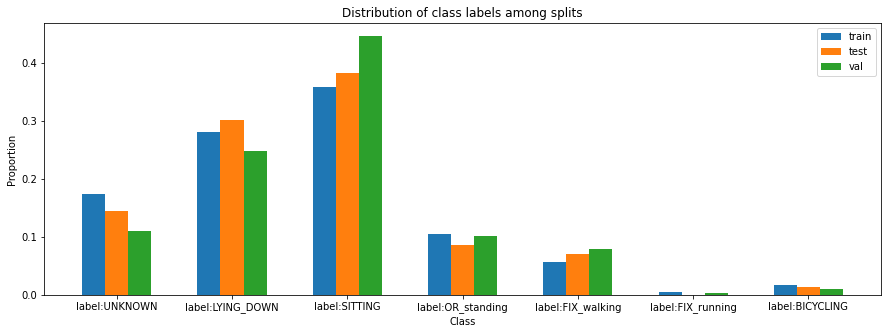

In [11]:
# What is the label distribution?
train_x, train_y = preProcess(train)
test_x, test_y = preProcess(test)
val_x, val_y = preProcess(val)
#del train_x, test_x, val_x

train_y = train_y.value_counts(normalize=True).sort_index()
test_y  = test_y.value_counts(normalize=True).sort_index()
val_y =  val_y.value_counts(normalize=True).sort_index()

X = main_activity_label_classes.keys()
X_axis = np.arange(len(X))

plt.figure(figsize=(15,5))
plt.bar(X_axis-0.2, train_y, width=0.2, label= 'train')
plt.bar(X_axis, test_y, width=0.2, label= 'test')
plt.bar(X_axis+0.2, val_y, width=0.2, label= 'val')
plt.xticks(X_axis, X)
plt.legend()
plt.ylabel('Proportion')
plt.xlabel('Class')
plt.title('Distribution of class labels among splits')
plt.show()

In [12]:
combined = pd.concat([train_x, test_x, val_x])

In [42]:
lof = LocalOutlierFactor(n_neighbors=20)
y_pred = lof.fit_predict(np.array(combined['raw_acc:3d:mean_x']).reshape(-1, 1))

In [44]:
np.unique(y_pred, return_counts=True)

array([   433, 308221], dtype=int64)

array([-1,  1])

In [37]:
y_pred.shape

(308654,)